# Generating Deep Neural Network Model Explanations via ChemML's Explain Module

### The `chemml.explain` module has three eXplainable AI (XAI) methods - DeepSHAP, LRP, and LIME. It allows both local (for a single instance) and global (aggregated for multiple instances) explanations. The explainations are in the form of a relevance score attributed to each feature used to build the DNN model.

We use a sample dataset from ChemML library which has the SMILES codes and 200 Dragon molecular descriptors (features) for 500 small organic molecules with their densities in $kg/m^3$. We split the dataset into training and testing subsets and scale them. We then build and train a pytorch DNN on the training subset.

In [1]:
import pandas as pd
import shap
from chemml.models import MLP
from chemml.datasets import load_organic_density

from sklearn.preprocessing import StandardScaler
from chemml.explain import Explain

_, y, X = load_organic_density()
columns = list(X.columns)

y = y.values.reshape(y.shape[0], 1).astype('float32')
X = X.values.reshape(X.shape[0], X.shape[1]).astype('float32')

# split 0.9 train / 0.1 test
ytr = y[:450, :]
yte = y[450:, :]
Xtr = X[:450, :]
Xte = X[450:, :]

scale = StandardScaler()
scale_y = StandardScaler()
Xtr = scale.fit_transform(Xtr)
Xte = scale.transform(Xte)
ytr = scale_y.fit_transform(ytr)

# PYTORCH
r1_pytorch = MLP(engine='pytorch',nfeatures=Xtr.shape[1], nneurons=[100,100,100], activations=['ReLU','ReLU','ReLU'],
        learning_rate=0.001, alpha=0.0001, nepochs=100, batch_size=100, loss='mean_squared_error', 
        regression=True, nclasses=None, layer_config_file=None, opt_config='Adam')

r1_pytorch.fit(Xtr, ytr)
engine_model = r1_pytorch.get_model()
engine_model.eval()

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


Sequential(
  (0): Linear(in_features=200, out_features=100, bias=True)
  (1): Linear(in_features=100, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=1, bias=True)
  (6): ReLU()
)

### DeepSHAP Explanations

We instantiate the `chemml.explain` object with an instance to be explained, the pytorch DNN object, and the feature names (columns). We then call the DeepSHAP method with a set of background or reference samples as directed by the [SHAP library](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html).

In [2]:
X_instance = Xtr[0]
exp = Explain(X_instance = X_instance, dnn_obj = engine_model, feature_names = columns)

explanation, shap_obj = exp.DeepSHAP(X_background = Xtr[1:10])

explanation

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,X4Av,X5Av,X0sol,X1sol,X2sol,X3sol,X4sol,X5sol,XMOD,RDCHI
0,0.004226,-0.017965,-0.002007,-0.000315,-0.00169,-0.000138,-0.005208,-0.047417,0.00027,-0.000075,...,-0.01016,-0.004733,-0.000346,0.000708,0.001949,0.001744,0.003523,0.003081,0.001851,-0.000127


### Visualizing local DeepSHAP explanations using a waterfall plot adapted from the shap library.

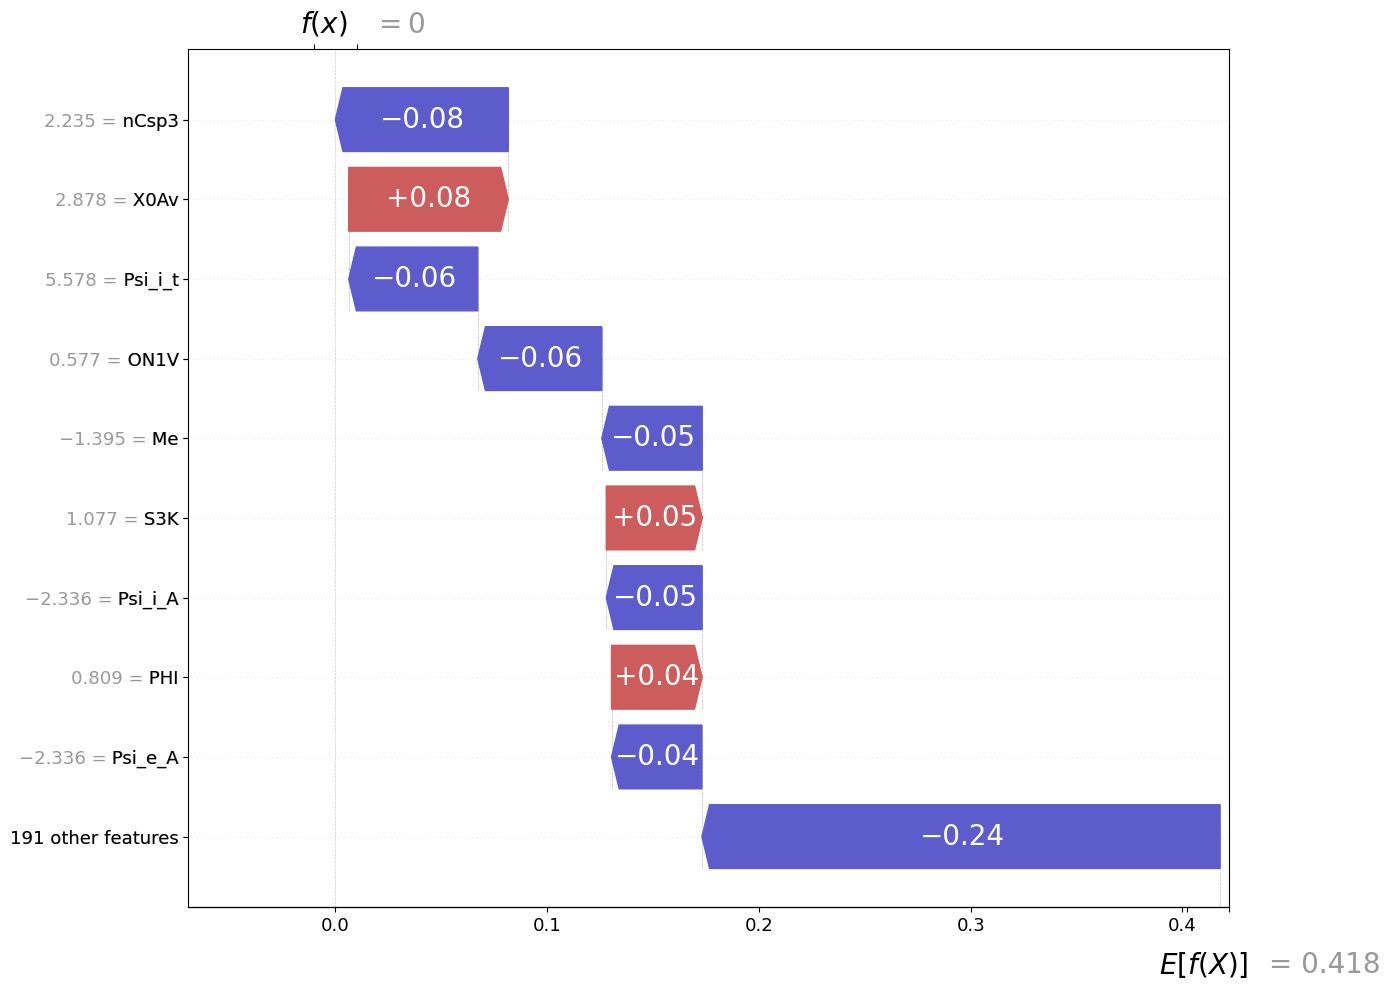

In [3]:
fig = exp.plot(local=True, rel_df=explanation,max_display=10, shap_obj=shap_obj)

In [4]:
X_instance = Xtr
exp = Explain(X_instance = X_instance, dnn_obj = engine_model, feature_names = columns)

explanation, shap_obj = exp.DeepSHAP(X_background = Xtr[1:10])

explanation

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,X4Av,X5Av,X0sol,X1sol,X2sol,X3sol,X4sol,X5sol,XMOD,RDCHI
0,0.004226,-0.017965,-0.002007,-0.000315,-0.001690,-0.000138,-0.005208,-0.047417,0.000270,-0.000075,...,-0.010160,-0.004733,-0.000346,0.000708,0.001949,0.001744,0.003523,0.003081,0.001851,-0.000127
1,-0.028730,0.016923,0.008729,0.001357,0.006194,0.000647,0.007421,0.095255,-0.015222,0.001943,...,0.010119,0.004144,-0.005155,-0.008186,-0.016180,-0.012706,-0.022199,-0.010823,-0.022696,0.000656
2,0.033408,-0.022131,-0.010370,-0.001949,-0.005127,-0.000974,-0.007972,-0.009267,-0.020344,0.002649,...,0.002977,0.002012,0.008781,0.011291,0.016925,0.012719,0.015563,0.004058,0.029044,-0.002798
3,-0.049662,0.035422,0.021034,0.002494,0.009761,0.001202,-0.011599,0.068437,-0.010441,-0.000044,...,-0.027242,-0.014504,-0.018708,-0.023040,-0.027916,-0.017599,-0.025875,-0.015381,-0.049061,0.005836
4,0.043910,0.027921,-0.007267,-0.001379,-0.004171,-0.000695,-0.002118,0.024150,0.002204,0.003459,...,0.001431,0.001361,0.007888,0.013086,0.018476,0.015196,0.030085,0.008146,0.041555,-0.001472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,0.005420,0.363526,0.021909,0.005207,0.012532,0.002856,0.063025,0.353158,0.146915,0.001592,...,-0.000388,0.000952,-0.007028,-0.001970,-0.001590,0.001733,0.010887,-0.009257,0.012901,0.002078
446,0.022738,-0.000947,-0.008990,-0.000644,-0.005321,-0.000275,0.008555,-0.076582,0.034864,-0.003276,...,0.001233,0.001632,0.007859,0.008330,0.015024,0.011447,0.016477,0.011646,0.016196,-0.001541
447,0.040769,-0.017716,-0.012482,-0.002395,-0.006325,-0.001261,-0.006515,-0.010023,-0.017198,0.004421,...,0.004269,0.002139,0.011364,0.014354,0.018635,0.012219,0.019320,0.013332,0.037022,-0.002666
448,0.031687,0.000953,-0.011975,-0.001535,-0.007395,-0.000637,0.007118,-0.048946,0.023622,-0.005410,...,0.002070,0.000787,0.008766,0.011670,0.019803,0.014711,0.023315,0.013825,0.028351,-0.001976


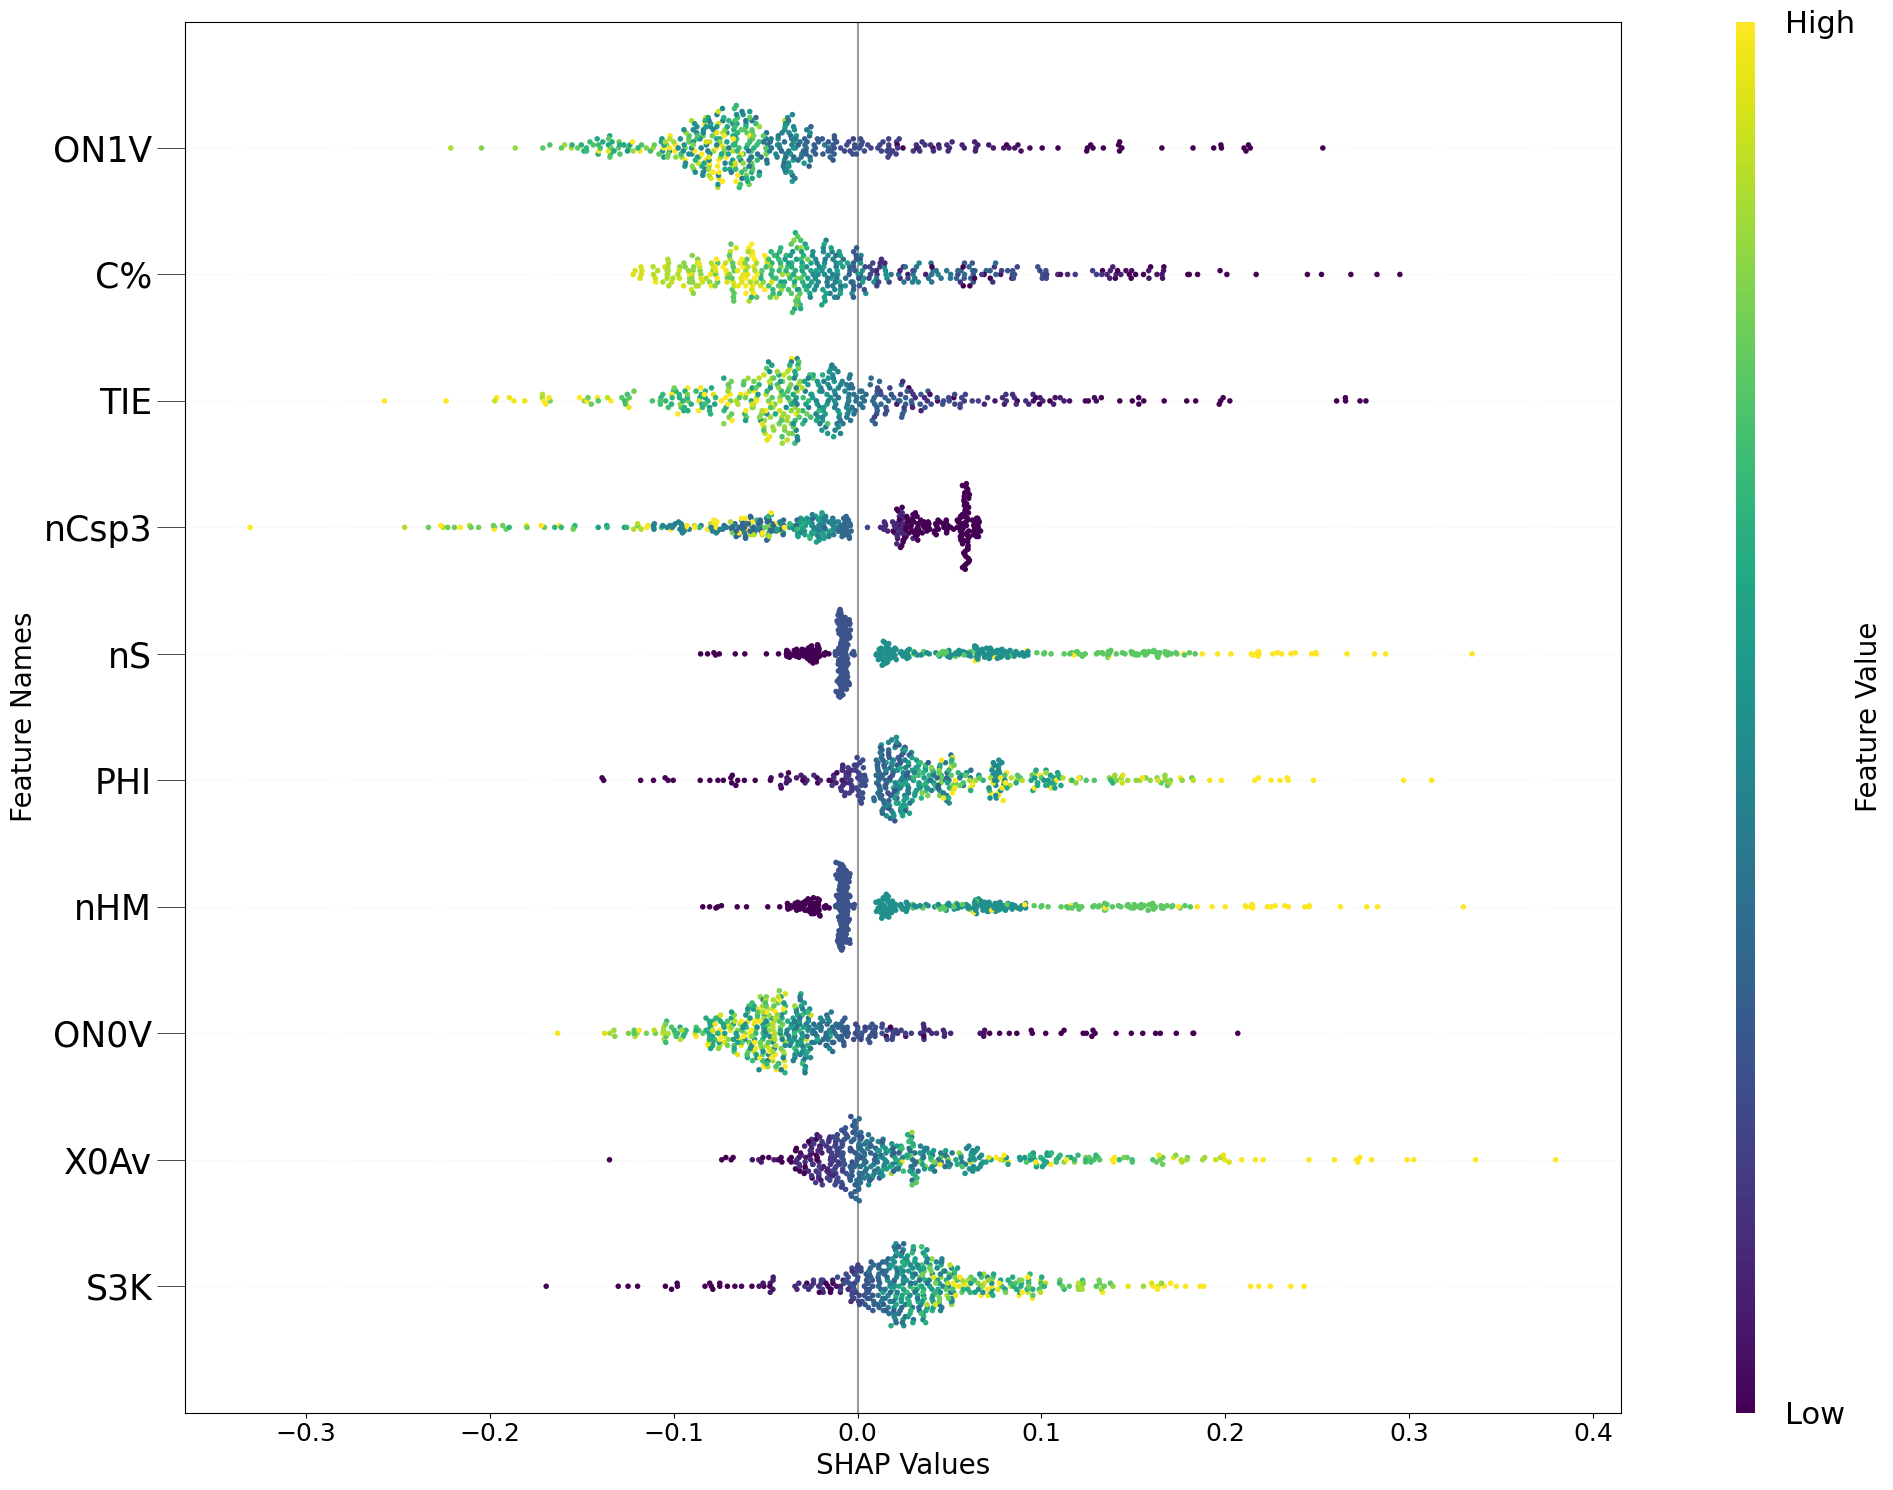

In [5]:
fig = exp.plot(local=False, rel_df=explanation,max_display=10, shap_obj=shap_obj)

In [6]:
X_instance = Xtr[0]
exp = Explain(X_instance = X_instance, dnn_obj = engine_model, feature_names = columns)

explanation, gb = exp.LRP(strategy='zero', global_relevance=False)

explanation

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,X4Av,X5Av,X0sol,X1sol,X2sol,X3sol,X4sol,X5sol,XMOD,RDCHI
0,3.852358e-08,5.460922e-08,-9.916600e-09,-4.480899e-11,-1.985339e-09,1.119740e-10,2.441856e-08,9.313563e-08,2.732422e-08,-4.074020e-12,...,4.698213e-08,2.548810e-08,1.979194e-08,1.979182e-08,2.497676e-08,1.692370e-08,2.368907e-08,1.703364e-08,3.827584e-08,-1.943156e-09


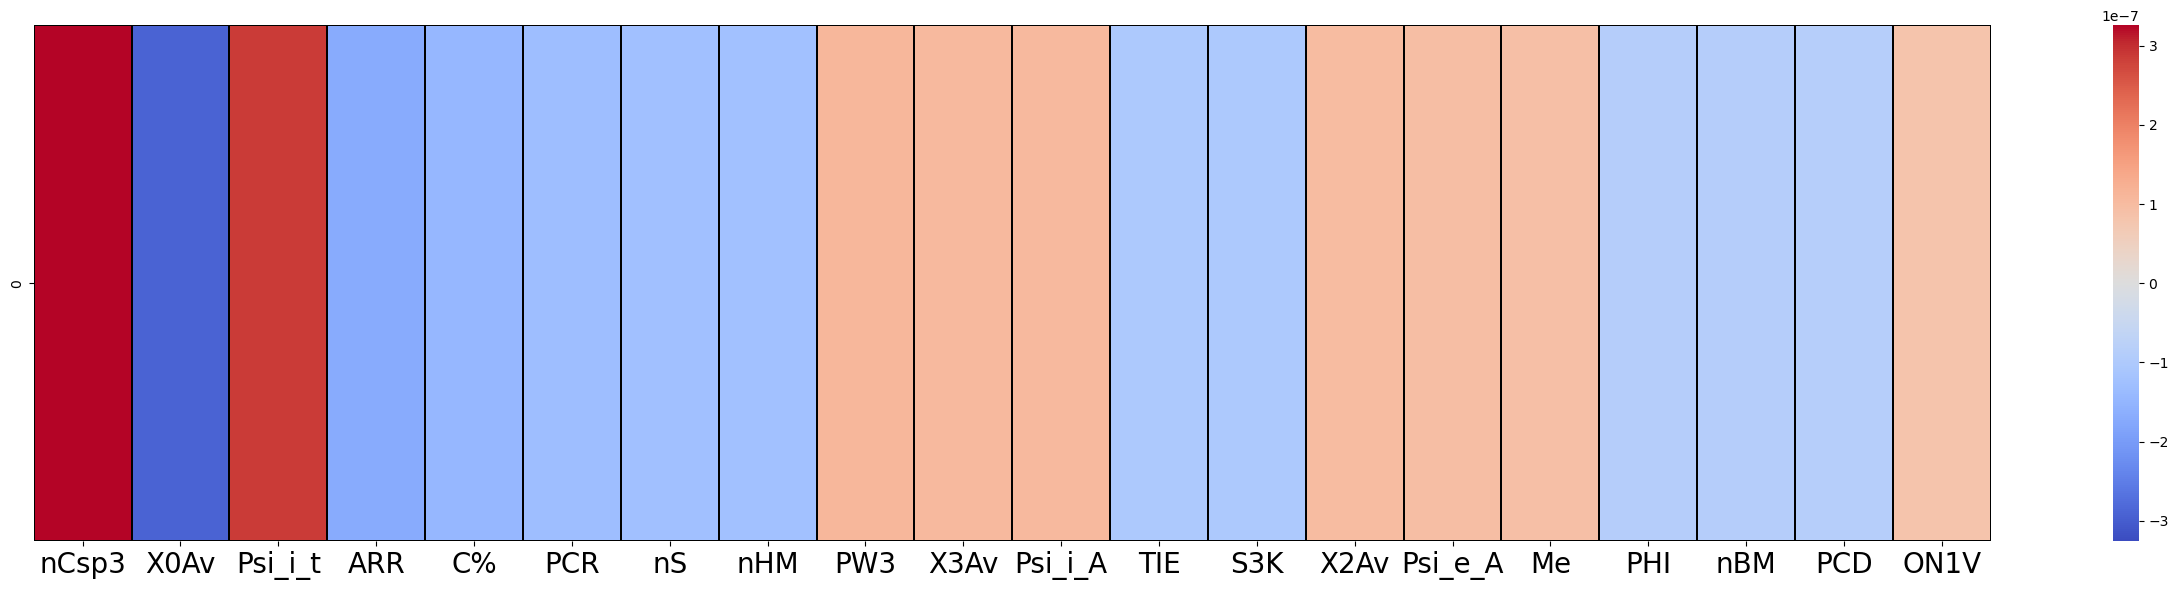

In [7]:
f = exp.plot(local=True,rel_df = explanation, max_display=20)

In [8]:
# strategies + global relevance
X_instance = Xte

exp = Explain(X_instance = X_instance, dnn_obj = engine_model, feature_names = columns)

explanation, gb = exp.LRP(strategy='zero', global_relevance=True)
explanation.head()

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,X4Av,X5Av,X0sol,X1sol,X2sol,X3sol,X4sol,X5sol,XMOD,RDCHI
0,-5.442207e-08,-2.982853e-08,2.167618e-08,1.767643e-09,1.544903e-08,2.695936e-10,-2.647259e-08,6.734375e-08,-6.808682e-08,4.042306e-08,...,-2.645516e-09,2.371978e-09,-1.195341e-08,-1.840679e-08,-4.198224e-08,-3.480988e-08,-5.390743e-08,-2.671428e-08,-5.087783e-08,4.358562e-09
1,8.878673e-08,1.464898e-08,-1.634698e-08,1.121170e-09,-5.942520e-09,1.903390e-09,-4.117974e-09,-7.421733e-08,3.227762e-08,2.386731e-09,...,-1.618912e-08,-7.629301e-09,2.081515e-08,2.930467e-08,5.053745e-08,4.399344e-08,7.572330e-08,4.249878e-08,6.686418e-08,-4.847356e-10
2,-3.456890e-08,2.978082e-08,2.267381e-08,3.525580e-09,1.493623e-08,8.980043e-10,-1.094076e-08,7.575872e-08,-2.154179e-08,2.333245e-08,...,-4.833615e-09,3.671629e-09,-1.171651e-08,-1.357215e-08,-3.296293e-08,-2.410476e-08,-2.585398e-08,-1.818333e-08,-2.818089e-08,4.308143e-09
3,6.546318e-08,5.663755e-08,-1.276156e-08,4.163062e-11,-4.969179e-09,5.639444e-10,1.548547e-08,1.039503e-08,4.969042e-08,6.748551e-10,...,-1.720700e-09,-6.601595e-10,1.903842e-08,2.377851e-08,3.843494e-08,2.994525e-08,4.649269e-08,2.829363e-08,5.432086e-08,-1.720702e-09
4,-1.094605e-02,-1.553468e-02,3.649520e-03,1.930702e-04,2.881745e-03,1.039482e-04,-6.698072e-03,2.903534e-02,-2.484877e-02,2.538170e-03,...,3.578953e-03,9.798985e-04,-3.169378e-03,-3.421158e-03,-7.285994e-03,-5.613479e-03,-1.128355e-02,-1.236324e-02,-8.190678e-03,-4.538567e-04


In [9]:
gb

,Mean Absolute Relevance Score,Mean Relevance Score
ON1V,5.134295e-02,4.494847e-02
TIE,4.496903e-02,3.684134e-02
C%,4.285664e-02,2.698204e-02
nHet,3.856633e-02,3.766285e-02
nCsp3,3.469539e-02,1.218661e-02
...,...,...
MPC06,1.640874e-04,-1.400087e-04
ZM1Kup,7.580742e-05,6.333340e-05
Psi_e_0d,4.498837e-05,4.498822e-05
Psi_i_1d,2.599327e-06,2.534556e-06


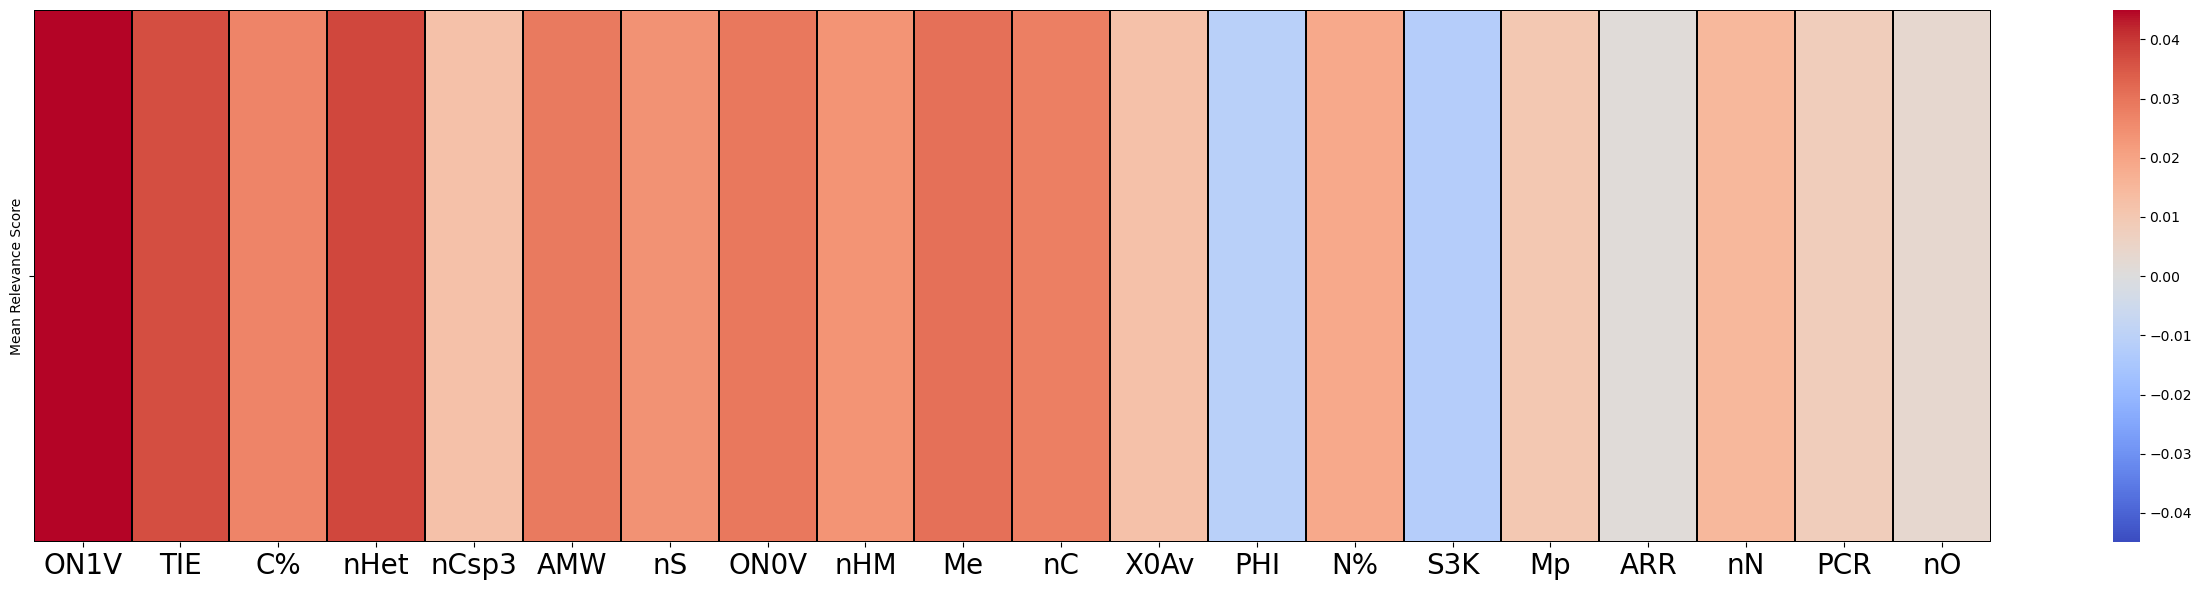

In [10]:
f = exp.plot(local=False,rel_df = gb, max_display=20)

In [11]:
X_instance = Xte[0:3]
exp = Explain(X_instance = X_instance, dnn_obj = engine_model, feature_names = columns)
explanation = exp.LIME(training_data=Xtr)
print(explanation)

Intercept 0.4380609945792554
Prediction_local [-0.08527803]
Right: 0.0
Intercept 0.40218305862638054
Prediction_local [0.39777754]
Right: 0.0
Intercept 0.5757294857850958
Prediction_local [-0.27969124]
Right: 0.0
[                    labels  local_relevance
0                C% > 0.87    -1.129633e-01
1            nHet <= -0.60    -9.151605e-02
2                nC > 0.73    -8.467723e-02
3                Mp > 0.66     7.224304e-02
4               PW2 > 0.60     6.047326e-02
..                     ...              ...
195   -0.12 < GMTI <= 0.84     2.784028e-04
196            GNar > 0.73    -1.954540e-04
197  -0.06 < SMTIV <= 0.86     1.333702e-05
198   -0.12 < SMTI <= 0.83     3.270500e-06
199     -0.03 < X0 <= 1.05    -3.281857e-07

[200 rows x 2 columns],                    labels  local_relevance
0           ON1V <= -0.62         0.161804
1            TIE <= -0.66         0.160159
2           ON0V <= -0.64         0.114473
3             nS <= -0.60        -0.111190
4           X0Av <

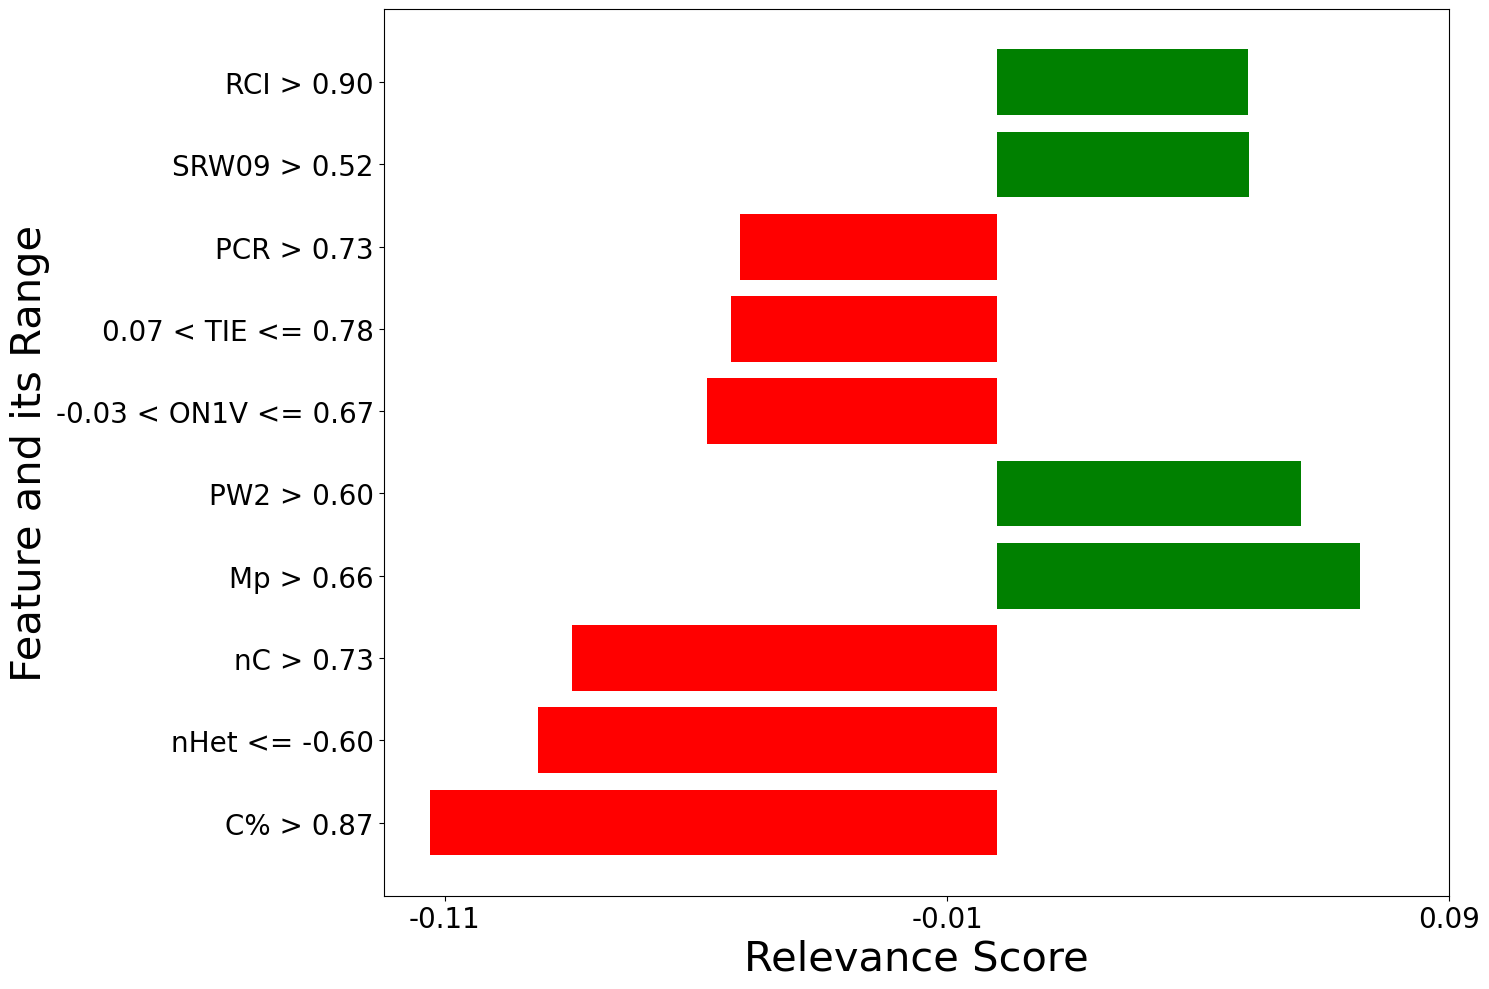

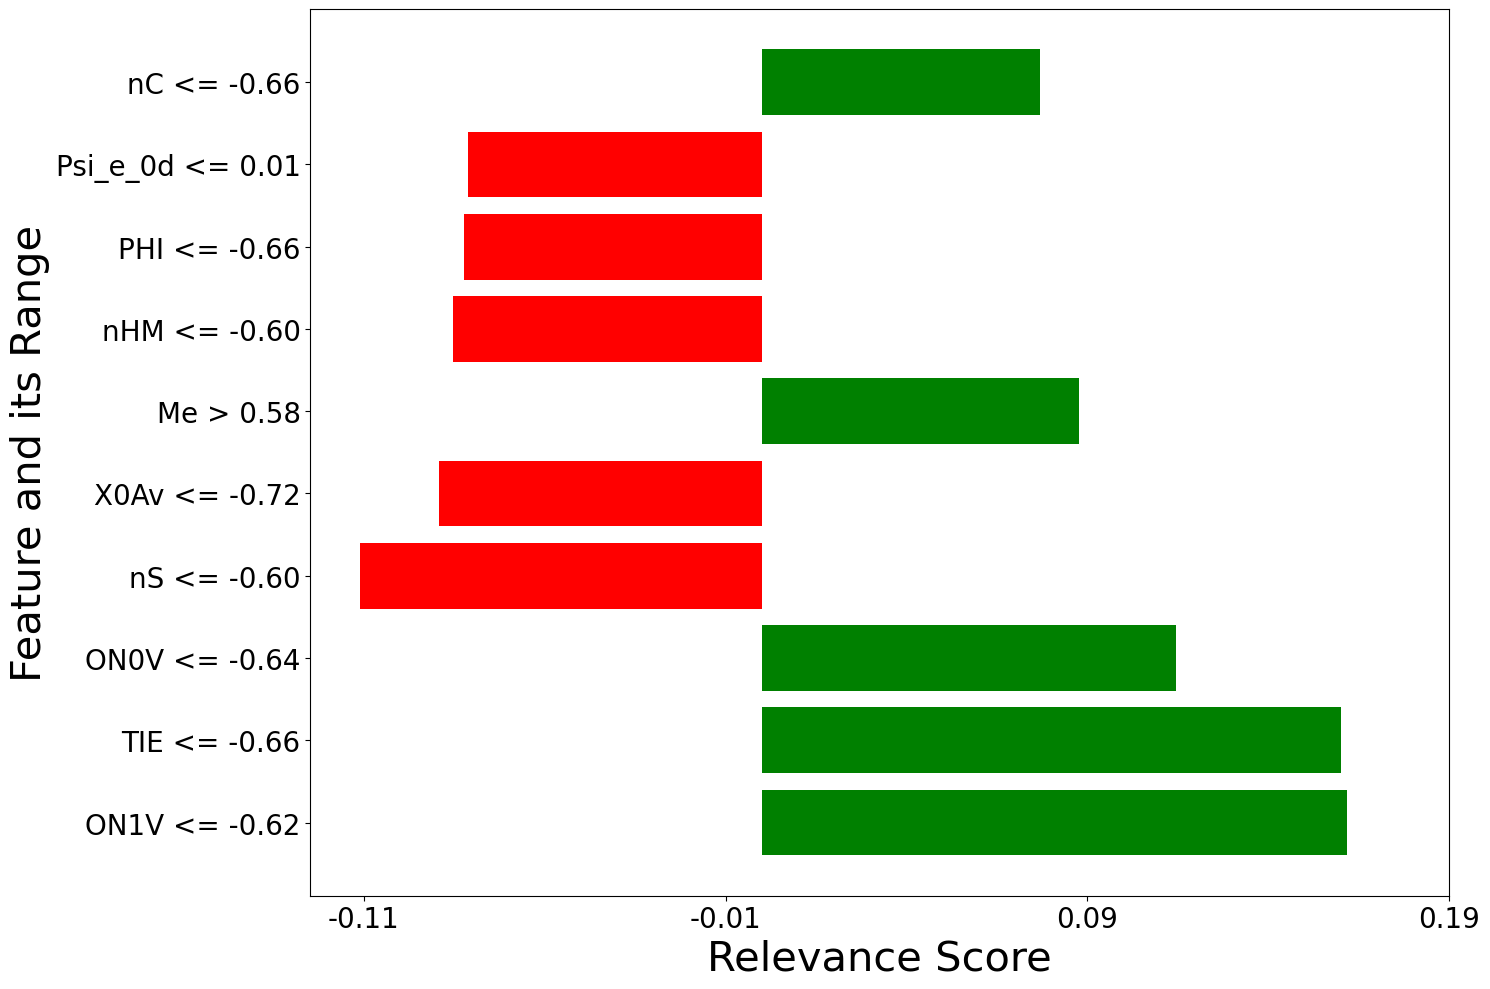

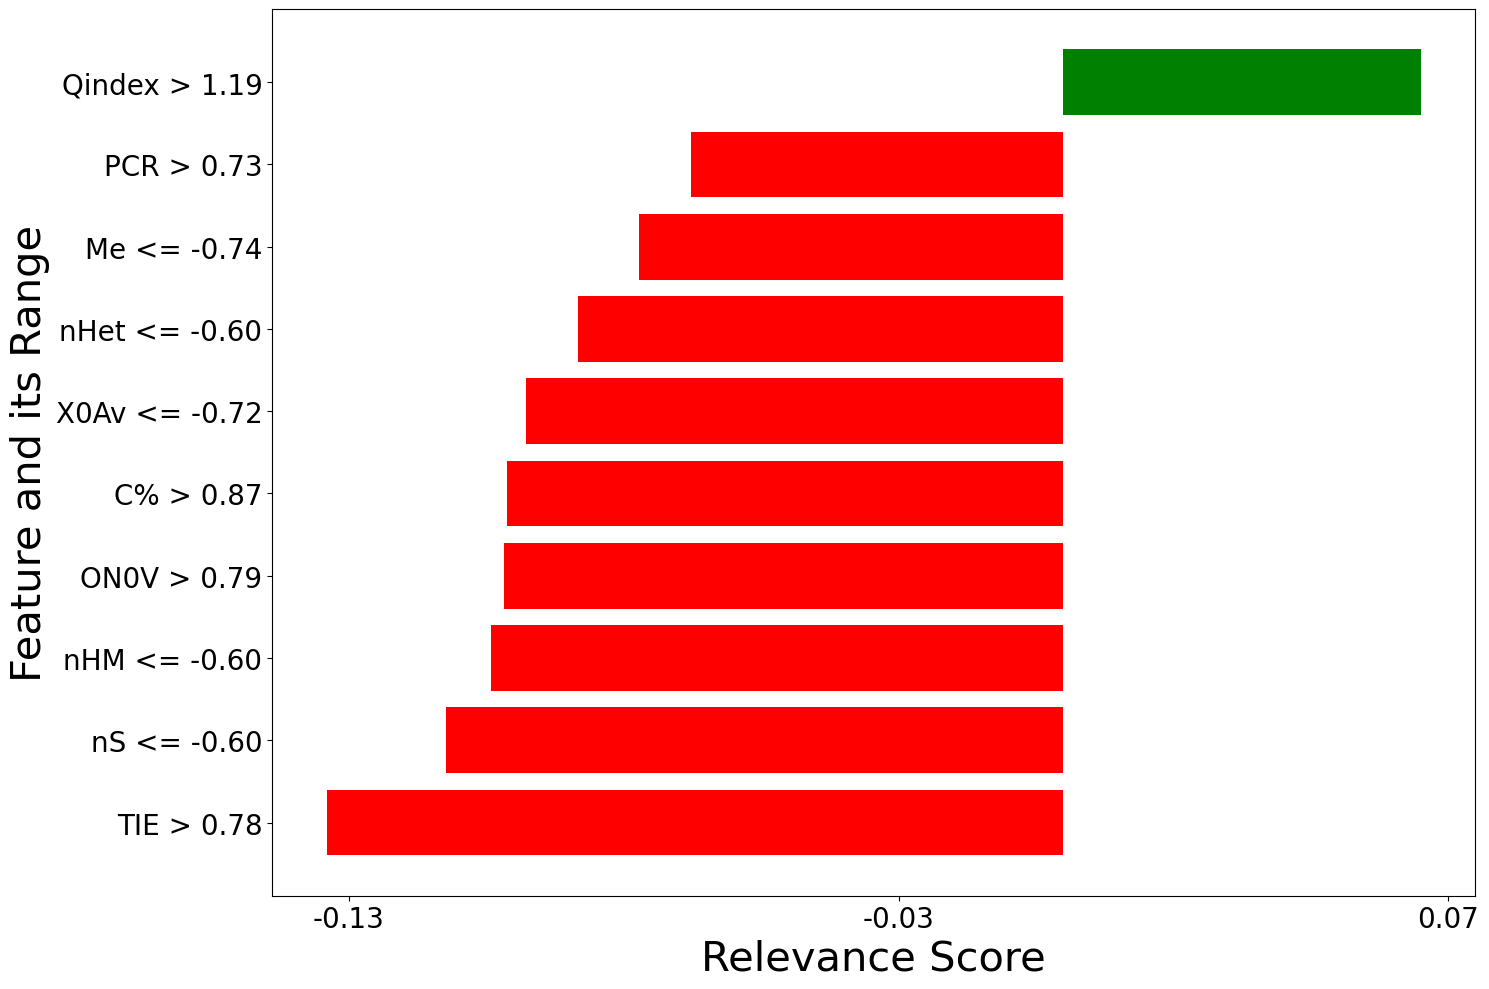

In [12]:
f=[]
for local_explanation in explanation:
    f.append(exp.plot(local=True, rel_df = local_explanation, max_display=10))